# Part 1: Image Classification — Fashion‑MNIST (11 points)

**Goal:** Build and train a lightweight CNN on Fashion‑MNIST following the given architecture and specs.

In [ ]:
# import something you may find useful
import os, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

# set seed
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# create a folder to save data
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

<div class="alert alert-success">
    <h3>1) Data</h3>
    load Fashion‑MNIST and create train/val/test splits (1 point)
</div>

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Use the following code to load the Fashion-MNIST if you want, or you can download the data manually
train_full = datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=transform)
test_ds = datasets.FashionMNIST(root=data_dir, train=False, download=True, transform=transform)


In [ ]:
# CODE HERE
# Define the training, validation, and test datasets. 
# Note that you may want to select the validation set from the training set by randomly splitting the data
train_size = int(0.8 * len(train_full))
val_size = len(train_full) - train_size
train_ds, val_ds = random_split(
    train_full,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)


batch_size = 64
# You may want to verify the data
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

len(train_ds), len(val_ds), len(test_ds)

<div class="alert alert-success">
    <h3>2) Model</h3>
    Build the CNN model (3 points)
</div>

In [ ]:
# Define the network architecture
class SmallCNN(nn.Module):
    def __init__(self):
        # CODE HERE
        # Define the convolutional layers, pooling layers...

        # Architecture:
        # Conv(1 -> 10, k=3) -> ReLU -> MaxPool(2)
        # Conv(10 -> 5, k=3) -> ReLU -> MaxPool(2)
        # Conv(5 -> 16, k=3) -> ReLU -> MaxPool(2)
        # Flatten -> FC(16 -> 10)
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=3),   # 1x28x28 -> 10x26x26
            nn.ReLU(),
            nn.MaxPool2d(2),                  # 10x13x13

            nn.Conv2d(10, 5, kernel_size=3),  # 5x11x11
            nn.ReLU(),
            nn.MaxPool2d(2),                  # 5x5x5

            nn.Conv2d(5, 16, kernel_size=3),  # 16x3x3
            nn.ReLU(),
            nn.MaxPool2d(2)                   # 16x1x1
        )

        self.fc = nn.Linear(16, 10)  # 10 classes


    def forward(self, x):
        # CODE HERE
        # Implement the forward pass. Return the final output.
        x = self.features(x)
        x = torch.flatten(x, 1)  # (batch_size, 16)
        out = self.fc(x)
        
        return out
        
        

# You may want to verify the architecture of CNN
model = SmallCNN().to(device)
model

<div class="alert alert-success">
    <h3>3) Loss & Optimizer</h3>
    CrossEntropy + SGD (1 point)
</div>

In [ ]:
# CODE HERE



# You may want to verify the criterion and optimizer
# criterion, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

<div class="alert alert-success">
    <h3>4) Training loop</h3>
    track training and validation loss (1 points)
</div>

In [ ]:
# CODE HERE
# Train the network for each epoch
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc

# CODE HERE
# Evaluate the model on the validation set
@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc

<div class="alert alert-success">
    <h3>5) Run training</h3>
    ≥ 15 epochs (1 point)
</div>

In [ ]:
# CODE HERE
# Set the training epochs
epochs = 15
train_losses, val_losses, train_accs, val_accs = [], [], [], []


# CODE HERE
# Run the training epochs
for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss, va_acc = evaluate(model, val_loader, criterion, device)
    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    train_accs.append(tr_acc)
    val_accs.append(va_acc)

    print(f"Epoch {epoch}/{epochs} | "
          f"Train Loss: {tr_loss:.4f} Acc: {tr_acc*100:.2f}% | "
          f"Val Loss: {va_loss:.4f} Acc: {va_acc*100:.2f}%")
    

<div class="alert alert-success">
    <h3>6) Plot</h3>
    training vs validation loss (1 point)
</div>

In [ ]:
# CODE HERE
# Plot the "Training vs Validation Loss"
plt.figure()
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Fashion-MNIST)")
plt.legend()
plt.grid(True)

plt.show()

<div class="alert alert-success">
    <h3>7) Evaluate on test set</h3>
    report accuracy on test set. Then report the model performance by showing the test accuracy (1 point)
</div>

In [ ]:
# CODE HERE
# Test the model on the test set
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f"[Fashion-MNIST test] Loss = {test_loss:.4f} | Acc = {test_acc*100:.2f}%")

<div class="alert alert-success">
    <h3>8) Discussion prompts (2 point)</h3>
    (a) Which techniques from Table 3 report better performance than your method? Which performs worse? Why do you think this is the case? Briefly explain. (1 point)<br>
    (b) Do you have any other ideas about how to improve your method? Briefly explain. (1 point)
</div>

**(a)**  
According to Table 3, models with deeper CNN architectures or feature-rich methods such as SVMs generally perform better than my lightweight CNN because they have greater capacity and extract more complex patterns. Simpler methods like logistic regression or k-NN perform worse since they cannot effectively capture spatial information. My model sits in between these extremes, so its accuracy is reasonable for its small size.

**(b)**  
The model could be improved by increasing the number of filters or adding additional convolutional layers. Using techniques such as batch normalization, dropout, or switching from SGD to Adam could also stabilize and speed up training. Data augmentation (e.g., random crops or flips) would likely improve generalization as well.

# Part 2: Image Classification — CIAFR-100 (14 points)

**Goal:** Build and train a lightweight CNN on CIAFR-100 following the given architecture and specs.

In [40]:
# import something you may find useful
import os, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
import numpy as np

import matplotlib
import matplotlib.pyplot as plt


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)


Device: cpu


<div class="alert alert-success">
    <h3>1) Data</h3>
    load CIFAR-100 and create train/val/test splits (1 point)
</div>

In [41]:
# CIFAR-100 normalization stats
CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD = (0.2675, 0.2565, 0.2761)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])


# Load CIFAR-100 (train + test)
# Use the following code to load the CIFAR-100 if you want, or you can download the data manually
train_full = datasets.CIFAR100(root=data_dir, train=True,  download=True, transform=transform)
test_ds = datasets.CIFAR100(root=data_dir, train=False, download=True, transform=transform)



In [42]:
# CODE HERE
# Define the training, validation, and test datasets. 
# Note that you may want to select the validation set from the training set by randomly splitting the data

train_size = int(0.8 * len(train_full))
val_size = len(train_full) - train_size
train_ds, val_ds = random_split(
    train_full,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)


batch_size = 64
# You may want to verify the data
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

len(train_ds), len(val_ds), len(test_ds)

(40000, 10000, 10000)

<div class="alert alert-success">
    <h3>2) Model</h3>
    Build the CNN model (4 points)
</div>

In [43]:
# Define the network architecture
class SmallCNN(nn.Module):
    def __init__(self):
        # CODE HERE
        # Define the convolutional layers, pooling layers...
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32 -> 16

            nn.Conv2d(10, 5, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16 -> 8

            nn.Conv2d(5, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 8 -> 4
        )
        self.fc = nn.Linear(16 * 4 * 4, 100)



    def forward(self, x):
        # CODE HERE
        # Implement the forward pass. Return the final output.
        x = self.features(x)
        x = torch.flatten(x, 1)  # (batch, 16*2*2)
        out = self.fc(x)
        return out

        
        



# You may want to verify the architecture of CNN
model = SmallCNN().to(device)
model

SmallCNN(
  (features): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(10, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(5, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=256, out_features=100, bias=True)
)

<div class="alert alert-success">
    <h3>3) Loss & Optimizer</h3>
    CrossEntropy + SGD (1 point)
</div>

In [44]:
# CODE HERE
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


# You may want to verify the criterion and optimizer
# criterion, optimizer

<div class="alert alert-success">
    <h3>4) Training loop</h3>
    track training and validation loss (1 points)
</div>

In [45]:
# CODE HERE
# Train the network for each epoch
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc






# CODE HERE
# Evaluate the model on the validation set
@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc




<div class="alert alert-success">
    <h3>5) Run training</h3>
    ≥ 15 epochs (1 point)
</div>

In [46]:
# CODE HERE
# Set the training epochs
epochs = 25
train_losses, val_losses, train_accs, val_accs = [], [], [], []


# CODE HERE
# Run the training epochs
for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss, va_acc = evaluate(model, val_loader, criterion, device)
    
    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    train_accs.append(tr_acc)
    val_accs.append(va_acc)

    print(f"Epoch {epoch}/{epochs} | "
          f"Train Loss: {tr_loss:.4f} Acc: {tr_acc*100:.2f}% | "
          f"Val Loss: {va_loss:.4f} Acc: {va_acc*100:.2f}%")



Epoch 1/25 | Train Loss: 4.1965 Acc: 7.36% | Val Loss: 3.7321 Acc: 13.78%
Epoch 2/25 | Train Loss: 3.5236 Acc: 17.57% | Val Loss: 3.3384 Acc: 20.31%
Epoch 3/25 | Train Loss: 3.2279 Acc: 22.73% | Val Loss: 3.1653 Acc: 24.12%
Epoch 4/25 | Train Loss: 3.0422 Acc: 25.84% | Val Loss: 3.0837 Acc: 25.21%
Epoch 5/25 | Train Loss: 2.9455 Acc: 27.86% | Val Loss: 3.0408 Acc: 26.23%
Epoch 6/25 | Train Loss: 2.8594 Acc: 29.93% | Val Loss: 3.0585 Acc: 25.73%
Epoch 7/25 | Train Loss: 2.8063 Acc: 30.76% | Val Loss: 3.0367 Acc: 26.74%
Epoch 8/25 | Train Loss: 2.7693 Acc: 31.37% | Val Loss: 2.9800 Acc: 27.23%
Epoch 9/25 | Train Loss: 2.7323 Acc: 32.20% | Val Loss: 3.0036 Acc: 27.73%
Epoch 10/25 | Train Loss: 2.7090 Acc: 32.78% | Val Loss: 2.9452 Acc: 28.87%
Epoch 11/25 | Train Loss: 2.6788 Acc: 33.13% | Val Loss: 2.9466 Acc: 28.46%
Epoch 12/25 | Train Loss: 2.6702 Acc: 33.37% | Val Loss: 2.9538 Acc: 28.22%
Epoch 13/25 | Train Loss: 2.6443 Acc: 34.05% | Val Loss: 2.9926 Acc: 27.70%
Epoch 14/25 | Train Lo

<div class="alert alert-success">
    <h3>6) Plot</h3>
    training vs validation loss (1 point)
</div>

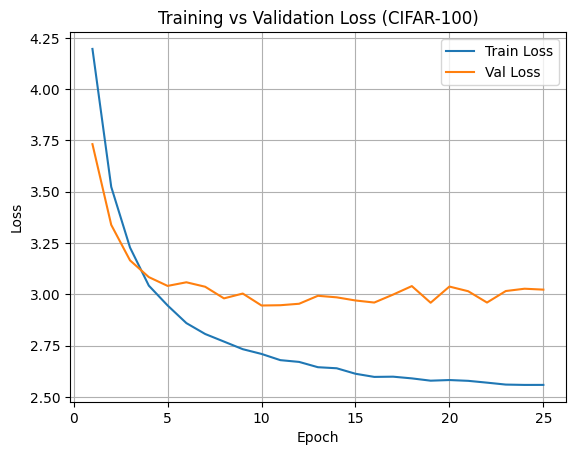

In [47]:
# CODE HERE
plt.figure()
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (CIFAR-100)")
plt.legend()
plt.grid(True)

plt.show()

<div class="alert alert-success">
    <h3>7) Evaluate on test set</h3>
    report accuracy (1 point)
</div>

In [48]:
# CODE HERE
# Test the model on the test set
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f"[CIFAR-100 test] Loss = {test_loss:.4f} | Acc = {test_acc*100:.2f}%")

[CIFAR-100 test] Loss = 3.0156 | Acc = 28.44%


<div class="alert alert-success">
    <h3>8) Discussion prompts (4 points)</h3>
    (a) Compared to your Fashion-MNIST results in Part 1, how did the training and validation curves change on CIFAR-100? Did you observe more overfitting, underfitting, or slower convergence? Explain briefly. (1 point)<br>
    (b) Based on the ResNet results above (around $80\%$ accuracy) and your own results (around $35$-$45\%$), what architectural differences do you think account for most of the performance gap? Consider depth, width (number of channels), skip connections, and data augmentation, and any modifications you have made to your own architecture. (2 point)<br>
    (c) What change did you make to your architecture that you were most surprised about?
This could be a large increase or decrease in performance, or something you added that
didn’t change anything. What is your big takeaway from that experience? (1 point)<br>
    
</div>